<a href="https://colab.research.google.com/github/followviny/FDR/blob/main/cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


FDR - expected (# false positive results/ # total positive test results) \\

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd

In [ ]:
np.random.seed(42)
obs = 10000
null_scores = np.random.normal(loc=0, scale=1, size=obs)    # null distribution with mean at 0
targ_scores = np.random.normal(loc=3, scale=1, size=obs)    # target distribution with mean at 3 for the overlap

In [ ]:
all_scores = np.concatenate([null_scores, targ_scores])
labels = np.concatenate([np.zeros(obs), np.ones(obs)])
df = pd.DataFrame({
    'scores': all_scores,
    'true_label': labels
})
df

,scores,true_label
0,0.496714,0.0
1,-0.138264,0.0
2,0.647689,0.0
3,1.523030,0.0
4,-0.234153,0.0
...,...,...
19995,3.387827,1.0
19996,4.377367,1.0
19997,3.378354,1.0
19998,4.713530,1.0


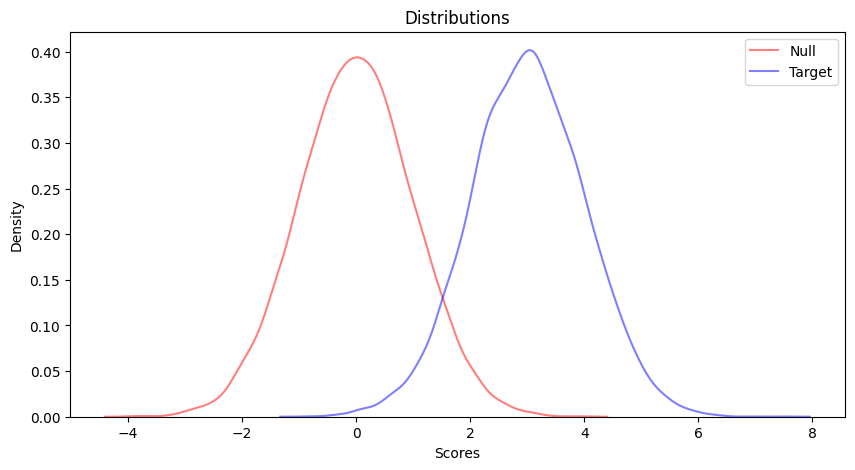

In [ ]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df[df['true_label'] == 0]['scores'], label='Null', color='red', alpha=0.5)
sns.kdeplot(data=df[df['true_label'] == 1]['scores'], label='Target', color='blue', alpha=0.5)
plt.title('Distributions')
plt.xlabel('Scores')
plt.ylabel('Density')
plt.legend()

Calculating right-tailed p-values as $1-cdf(x)$ for each score. This is the probability that a random variable under the **null hypothesis** would take a value $\geq$ $x$. For small $x$ it would be large, and for large vice versa(to reject the null hypothesis).

In [ ]:
df['p_value'] = 1 - stats.norm.cdf(df['scores'], loc=0, scale=1)

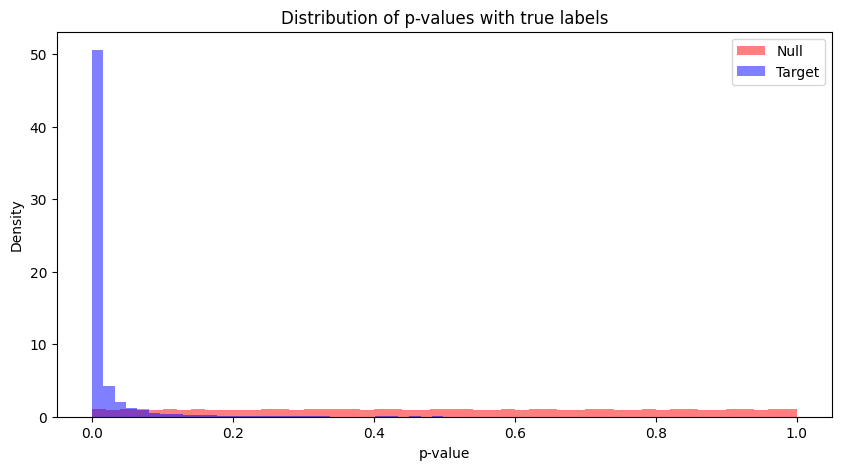

Median p-value (null): 0.5010
Median p-value (target): 0.0013


In [ ]:
plt.figure(figsize=(10, 5))
null_pvals = df[df['true_label'] == 0]['p_value']
targ_pvals = df[df['true_label'] == 1]['p_value']
plt.hist(null_pvals, bins=50, alpha=0.5, color='red', density=True,
         label='Null')
plt.hist(targ_pvals, bins=50, alpha=0.5, color='blue', density=True,
         label='Target')

plt.xlabel('p-value')
plt.ylabel('Density')
plt.title('Distribution of p-values with true labels')
plt.legend()
plt.show()

print(f"Median p-value (null): {np.median(null_pvals):.4f}")
print(f"Median p-value (target): {np.median(targ_pvals):.4f}")

Null p-values are uniform (under the null hypothesis any value within this range is equally likely) and for target distribution most values are shifted right compared to null (mean 3) --> most get very small p-values.

### Benjamini-Hochberg (original)
I read this: [benjamini_hochberg1995](https://www.researchgate.net/publication/221995234_Controlling_The_False_Discovery_Rate_-_A_Practical_And_Powerful_Approach_To_Multiple_Testing)

1. **Set FDR level**: Choose a significance level $\alpha$ (e.g., $\alpha = 0.05$).

2. **Order p-values**: Arrange the p-values $p_1, p_2, \dots, p_m$ from $m$ hypothesis tests in ascending order:
   $
   p_{(1)} \leq p_{(2)} \leq \dots \leq p_{(m)}
   $

3. **Calculate thresholds**: For each rank $i$ (where $i = 1, 2, \dots, m$), calculate threshold:
   $
   \frac{i \cdot \alpha}{m}
   $

4. **Find largest significant p-value**: Find the largest $i$ such that:
   $
   p_{(i)} \leq \frac{i \cdot \alpha}{m}
   $

5. **Reject null hypotheses**: Reject the null hypotheses for all tests with p-values $p_{(1)}, p_{(2)}, \dots, p_{(i)}$.


P.S. I know it can be done using scipy.stats, I just wanted to understand.

$\alpha$ - acceptable level of FDR. It controls the expected proportion of false discoveries (incorrectly rejected null hypotheses) among the hypotheses that are declared significant.

In [ ]:
alpha = 0.05     # allow 5% of false discoveries among all significant

In [ ]:
def b_h(p_values, alpha=0.05):                             # 1
    n = len(p_values)

    ranks = np.arange(1, n + 1)
    thresholds = (ranks / n) * alpha                       # 3

    below_thresholds = p_values <= thresholds
    significant = np.zeros(n, dtype=bool)

    if any(below_thresholds):
        max_i = np.max(np.where(below_thresholds))         # 4
        significant[:max_i + 1] = True                     # 5

    return significant, thresholds

df = df.sort_values('p_value').reset_index(drop=True)      # 2

significant, threshold_values = b_h(df['p_value'], alpha)
df['significant'] = significant
df['threshold'] = threshold_values

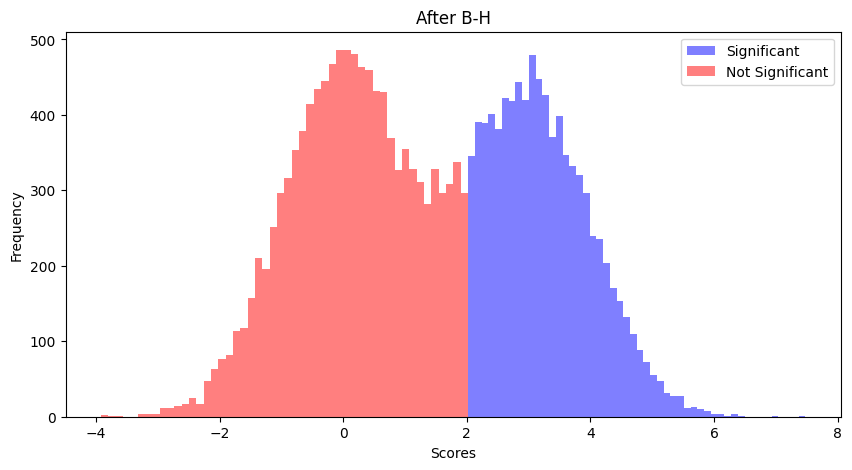

Number of significant discoveries at 5% FDR: 8685


In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(df[df['significant'] == True]['scores'], bins=50, alpha=0.5, color='blue', label='Significant')
plt.hist(df[df['significant'] == False]['scores'], bins=50, alpha=0.5, color='red', label='Not Significant')
plt.title('After B-H')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.legend()
plt.show()

num_significant = df['significant'].sum()
print(f"Number of significant discoveries at {int(alpha*100)}% FDR: {num_significant}")        # at 5% FDR

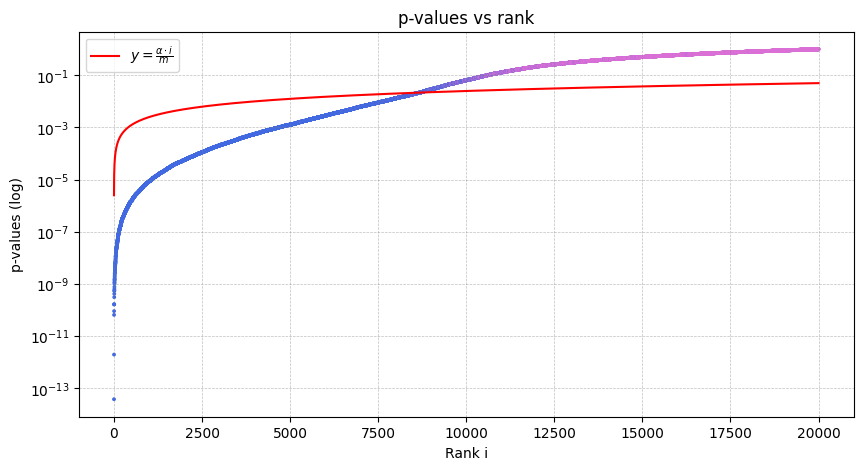

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(df.index + 1, df['p_value'], color=np.where(df['true_label'] == 0, 'orchid', 'royalblue'), s=3)
plt.plot(df.index + 1, df['threshold'], color='red', linestyle='-', label=r'$y = \frac{\alpha \cdot i}{m}$', linewidth=1.5)

plt.xlabel('Rank i')
plt.ylabel('p-values (log)')
plt.title('p-values vs rank')
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()


Below $y = \frac{\alpha \cdot i}{m}$ are the rejected null-hypotheses

In [ ]:
false_positives = sum((df['significant'] == True) & (df['true_label'] == 0))
total_positives = sum(df['significant'] == True)
actual_fdr = false_positives / total_positives
print(f"Actual FDR (proportion of false positives among all significant discoveries): {actual_fdr:.4f}")

Actual FDR (proportion of false positives among all significant discoveries): 0.0263


In [ ]:
true_positives = sum((df['significant'] == True) & (df['true_label'] == 1))
total_positives = sum(df['true_label'] == 1)
power = true_positives / total_positives
print(f"Power (true positive rate at {int(alpha*100)}% FDR): {power}")

Power (true positive rate at 5% FDR): 0.8457


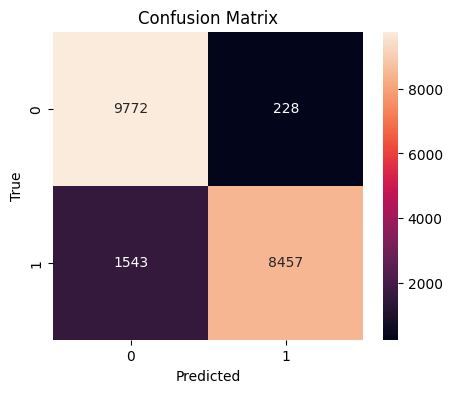

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df['true_label'], df['significant'])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Q-values (adjusted for $\pi_{0}$)
q-value for each p-value indicates the FDR threshold one would need to set in order for that test to be called significant. So they produce same results, but with q-values it's just easier to adjust $\alpha$, because there's no need to recalculate for the whole df.

1. Order p-values
2. For each p-value at rank $i$ calculate $q_{(i)} = \frac{m \cdot p_{(i)} \cdot π_{0}}{i}$ and adjust for $\pi_{0}$
3. Start from the largest rank and adjust each q-val as $q_{(i)} = \min(q_{(i)}, q_{(i+1)})$
4. Set an FDR threshold and identify all hypotheses below it as significant discoveries.

In [ ]:
pi0 = 0.5    # π0 = 0.5 (proportion of true null hypotheses directly from actual data for now)

In [ ]:
def q_val(p_values):
    n = len(p_values)
    q_values = np.zeros(n)

    min_q = 1.0
    for i in range(n-1, -1, -1):
        q = min(min_q, (n * p_values[i] * pi0) / (i + 1))
        q_values[i] = q
        min_q = q

    return q_values

df['q_value'] = q_val(df['p_value'])

In [ ]:
# alpha defined in the beginning
df['significant_q'] = df['q_value'] <= alpha
num_significant_q = df['significant_q'].sum()
print(f"Number of significant discoveries at {int(alpha*100)}% FDR : {num_significant_q}")

Number of significant discoveries at 5% FDR : 9624


In [ ]:
df

,scores,true_label,p_value,significant,threshold,q_value,significant_q
0,7.479084,1.0,3.741452e-14,True,0.000003,3.741452e-10,True
1,6.942331,1.0,1.928457e-12,True,0.000005,9.642287e-09,True
2,6.428910,1.0,6.426093e-11,True,0.000007,2.142031e-07,True
3,6.377768,1.0,8.984358e-11,True,0.000010,2.246089e-07,True
4,6.287761,1.0,1.610384e-10,True,0.000013,2.355141e-07,True
...,...,...,...,...,...,...,...
19995,-3.241514,0.0,9.994055e-01,False,0.049990,4.998027e-01,False
19996,-3.601085,0.0,9.998416e-01,False,0.049993,4.999781e-01,False
19997,-3.688365,0.0,9.998872e-01,False,0.049995,4.999781e-01,False
19998,-3.836656,0.0,9.999376e-01,False,0.049998,4.999781e-01,False


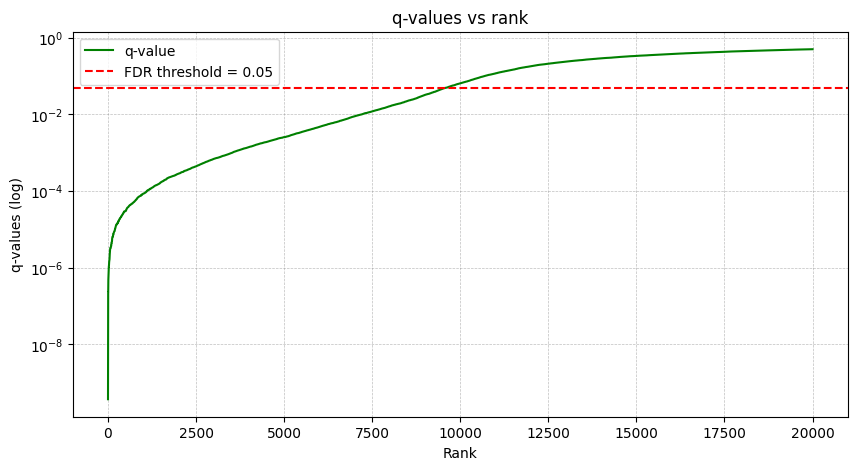

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df.index + 1, df['q_value'], label='q-value', color='green')
plt.axhline(y=alpha, color='red', linestyle='--', label=f'FDR threshold = {alpha}')
plt.xlabel('Rank')
plt.ylabel('q-values (log)')
plt.yscale('log')
plt.title('q-values vs rank')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()

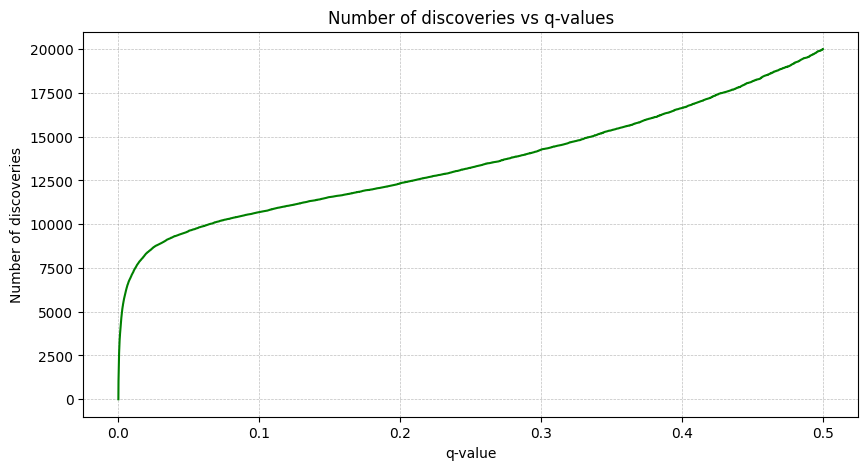

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['q_value'], df.index + 1, color='green')
plt.xlabel('q-value')
plt.ylabel('Number of discoveries')
plt.title('Number of discoveries vs q-values')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()

### Ground truth FDR
As FDR = $\frac{FP}{FP + TP}$

To measure the cumulative FDR , derived from true labels (ground truth)

I count FP and TP up to each rank, assuming these are discoveries that would be marked significant by the threshold.

So essentially it's a true proportion of false discoveries up to each rank assuming the threshold is put there.

In [ ]:
n = len(df)
fdr_truth = np.zeros(len(df))
false_discoveries = 0
total_discoveries = 0

for i in range(n):
    if df.loc[i, 'true_label'] == 0:
        false_discoveries += 1
    total_discoveries += 1
    fdr_truth[i] = false_discoveries / total_discoveries

In [ ]:
q_values_true = np.zeros(n)
min_q = 1.0
for i in range(n-1, -1, -1):
    min_q = min(min_q, fdr_truth[i])
    q_values_true[i] = min_q
df['q_values_true'] = q_values_true

In [ ]:
df

,scores,true_label,p_value,significant,threshold,q_value,significant_q,q_values_true
0,7.479084,1.0,3.741452e-14,True,0.000003,3.741452e-10,True,0.000000
1,6.942331,1.0,1.928457e-12,True,0.000005,9.642287e-09,True,0.000000
2,6.428910,1.0,6.426093e-11,True,0.000007,2.142031e-07,True,0.000000
3,6.377768,1.0,8.984358e-11,True,0.000010,2.246089e-07,True,0.000000
4,6.287761,1.0,1.610384e-10,True,0.000013,2.355141e-07,True,0.000000
...,...,...,...,...,...,...,...,...
19995,-3.241514,0.0,9.994055e-01,False,0.049990,4.998027e-01,False,0.499900
19996,-3.601085,0.0,9.998416e-01,False,0.049993,4.999781e-01,False,0.499925
19997,-3.688365,0.0,9.998872e-01,False,0.049995,4.999781e-01,False,0.499950
19998,-3.836656,0.0,9.999376e-01,False,0.049998,4.999781e-01,False,0.499975


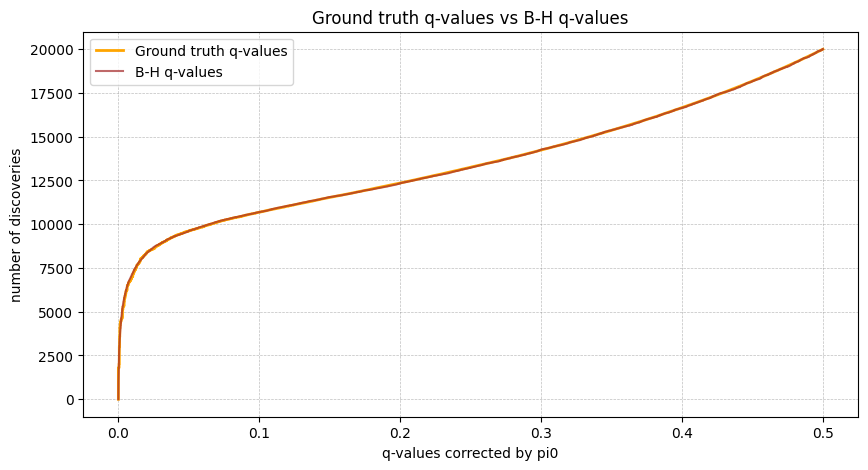

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['q_values_true'], df.index + 1, label='Ground truth q-values', color='orange', linewidth=2)
plt.plot(df['q_value'], df.index + 1, label='B-H q-values', color='brown', alpha=0.7)
plt.title('Ground truth q-values vs B-H q-values')
plt.xlabel('q-values corrected by pi0')
plt.ylabel('number of discoveries')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend()
plt.show()

**Ground truth q-values** are computed based on true labels of the dataset, which has 1:1 ratio of null to target observations -> constrained by 0.5.
* At lower ranks (high scores) true positives dominate (label=1), keeping the FDR low.
* At higher ranks (low scores) more false discoveries are added to the total, increasing the FDR to ≈ 0.5, reflecting the dataset's true ratio.

**B-H** q-values adjusted for true $\pi_{0}$ overlap

### Target-decoy approach
Generated decoy scores from null distribution

These decoy scores represent a baseline of what results one would expect if there were no true discoveries.

$FDR_{1} = \frac { \#decoy (pred.label = 0)}{\#target (pred.label = 1)}$ \\
Assumption: For every decoy labeled as a discovery, there’s a corresponding false target discovery. 1:1 ratio of false discoveries to decoys. \\
$FDR_{2} = \frac {2 \cdot \#decoy (pred.label = 0)}{\#target(pred.label = 1) + \# decoy (pred.label = 0)}$ \\
Doubles the contribution of decoys to account for the chance that decoy-based false discoveries might underestimate the real false positive rate.

In [ ]:
td_df = pd.DataFrame({
    'scores': df['scores'],           # from prev dataframe
    'true_label': df['true_label']
})
td_df['decoy_scores'] = td_df[td_df['true_label'] == 0]['scores'].sample(n=len(td_df), replace=True).values
# decoys from null distribution

In [ ]:
td_df['combined_max'] = np.maximum(td_df['scores'], td_df['decoy_scores'])
td_df['pred_label'] = td_df['scores'] > td_df['decoy_scores']
td_df = td_df.sort_values('combined_max', ascending=False).reset_index(drop=True)

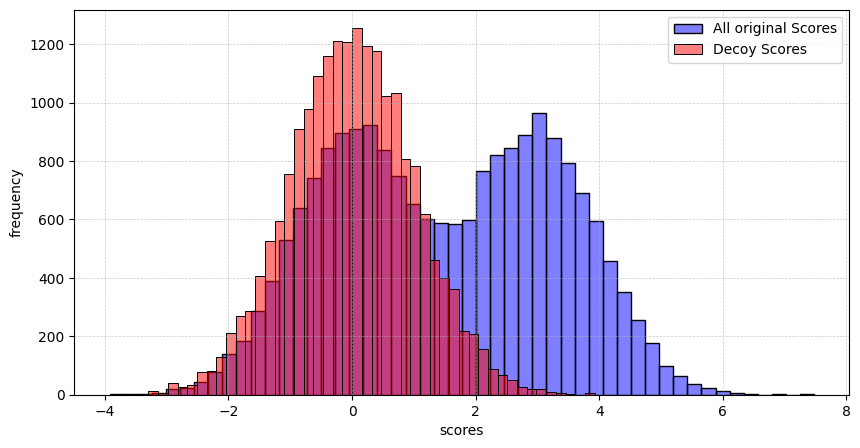

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(td_df['scores'], bins=50, color='blue', alpha=0.5, label='All original Scores')
sns.histplot(td_df['decoy_scores'], bins=50, color='red', alpha=0.5, label='Decoy Scores')
plt.ylabel('frequency')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.show()

FDR:

In [ ]:
n = len(td_df)
fdr1_values = np.zeros(n)
fdr2_values = np.zeros(n)

num_decoy_0 = 0
num_target_1 = 0

for i in range(n):
    if td_df.loc[i, 'pred_label'] == 0:
        num_decoy_0 += 1
    else:
        num_target_1 += 1

    fdr1_values[i] = num_decoy_0 / num_target_1  if num_target_1 > 0 else np.inf  # what if num_target_1 = 0 -> no true discoveries
    fdr2_values[i] = 2 * num_decoy_0 / (num_target_1 + num_decoy_0)

In [ ]:
q_fdr1 = np.zeros(n)
q_fdr2 = np.zeros(n)
min_q1 = 1.0
min_q2 = 1.0

for i in range(n-1, -1, -1):
    min_q1 = min(min_q1, fdr1_values[i])
    min_q2 = min(min_q2, fdr2_values[i])
    q_fdr1[i] = min_q1
    q_fdr2[i] = min_q2

td_df['q_FDR1'] = q_fdr1
td_df['q_FDR2'] = q_fdr2

In [ ]:
td_df

,scores,true_label,decoy_scores,combined_max,pred_label,q_FDR1,q_FDR2
0,7.479084,1.0,-1.482231,7.479084,True,0.000000,0.0000
1,6.942331,1.0,1.261519,6.942331,True,0.000000,0.0000
2,6.428910,1.0,-0.031261,6.428910,True,0.000000,0.0000
3,6.377768,1.0,1.477894,6.377768,True,0.000000,0.0000
4,6.287761,1.0,-0.656894,6.287761,True,0.000000,0.0000
...,...,...,...,...,...,...,...
19995,-1.957339,0.0,-2.219300,-1.957339,True,0.352814,0.5216
19996,-2.025040,0.0,-2.471645,-2.025040,True,0.352814,0.5216
19997,-2.072355,0.0,-3.922400,-2.072355,True,0.352814,0.5216
19998,-2.194382,0.0,-2.773815,-2.194382,True,0.352814,0.5216


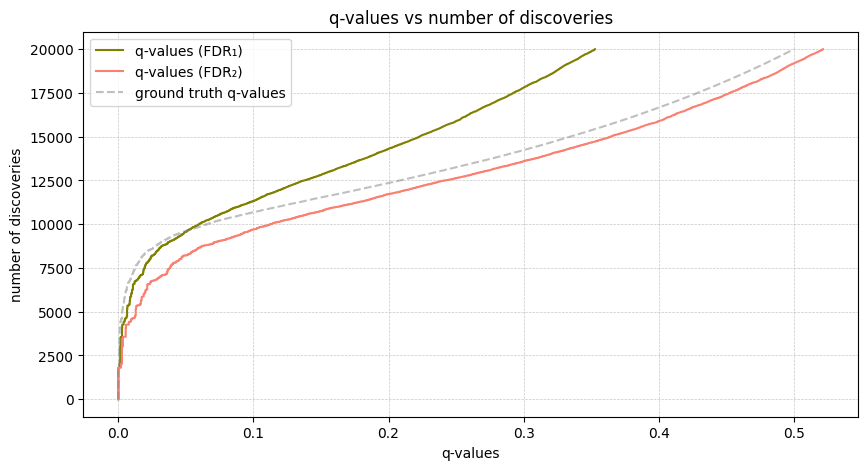

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(td_df['q_FDR1'], df.index + 1, label='q-values (FDR₁)', color='olive')
plt.plot(td_df['q_FDR2'], df.index + 1, label='q-values (FDR₂)', color='salmon')
plt.plot(df['q_values_true'], df.index + 1, label='ground truth q-values', color='grey', linestyle='--', alpha=0.5)
plt.title('q-values vs number of discoveries')
plt.xlabel('q-values')
plt.ylabel('number of discoveries')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()


BH relies on theoretical expectation of p-values from the null distribution, this method uses decoy scores as empirical evidence of false discoveries.